In [40]:
import os
import time
import cv2
import numpy as np
from skimage import segmentation
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [27]:
class Args(object):
    def __init__(self,path):
        self.input_image_path = path  # image/coral.jpg image/tiger.jpg
        self.train_epoch = 64 
        self.mod_dim1 = 64  #
        self.mod_dim2 = 32

        self.gpu_id=0
        self.min_label_num = 4  # if the label number small than it, break loop
        self.max_label_num = 256  # if the label number small than it, start to show result image.



In [28]:
class MyNet(nn.Module):
    def __init__(self, inp_dim, mod_dim1, mod_dim2):
        super(MyNet, self).__init__()

        self.seq = nn.Sequential(
            
            nn.Conv2d(inp_dim, mod_dim1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mod_dim1),
            nn.ReLU(inplace=True),
class MyNet(nn.Module):
    def __init__(self, inp_dim, mod_dim1, mod_dim2):
        super(MyNet, self).__init__()

        self.seq = nn.Sequential(
            
            nn.Conv2d(inp_dim, mod_dim1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mod_dim1),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim1, mod_dim2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mod_dim2),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim2, mod_dim1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mod_dim1),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim1, mod_dim2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mod_dim2),
        )

    def forward(self, x):
        return self.seq(x)
            nn.Conv2d(mod_dim1, mod_dim2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mod_dim2),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim2, mod_dim1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mod_dim1),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim1, mod_dim2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mod_dim2),
        )

    def forward(self, x):
        return self.seq(x)

In [37]:

def run(path,outputpath,features,flag=0):
    lossList=[]
    args = Args(path)
    torch.cuda.manual_seed_all(1943)
    np.random.seed(1943)
    os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_id)  # choose GPU:0
    image = cv2.imread(args.input_image_path)
    
    '''segmentation ML'''
    seg_map = segmentation.felzenszwalb(image, scale=32, sigma=0.5, min_size=64)
    # seg_map = segmentation.slic(image, n_segments=10000, compactness=100)
    seg_map = seg_map.flatten()
    seg_lab = [np.where(seg_map == u_label)[0]
               for u_label in np.unique(seg_map)]

    '''train init'''
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    if flag!=0:
        tensor = features.transpose((2, 0, 1))
    else:
        tensor = image.transpose((2,0,1))
    tensor = tensor.astype(np.float32) / 255.0
    tensor = tensor[np.newaxis, :, :, :]
    tensor = torch.from_numpy(tensor).to(device)
    #print(tensor.shape)
    
    #维度注意，对应通道数inp_dim
    if flag!=0:
        model = MyNet(inp_dim=features.shape[2], mod_dim1=args.mod_dim1, mod_dim2=args.mod_dim2).to(device)
    else:
        model = MyNet(inp_dim=3, mod_dim1=args.mod_dim1, mod_dim2=args.mod_dim2).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-1, momentum=0.0)

    image_flatten = image.reshape((-1, 3))
    color_avg = np.random.randint(255, size=(args.max_label_num, 3))
    show = image

    '''train loop'''
    model.train()
    for batch_idx in range(args.train_epoch):
        '''forward'''
        optimizer.zero_grad()
        output = model(tensor)[0]
        output = output.permute(1, 2, 0).view(-1, args.mod_dim2)
        target = torch.argmax(output, 1)
        im_target = target.data.cpu().numpy()

        '''refine'''
        for inds in seg_lab:
            u_labels, hist = np.unique(im_target[inds], return_counts=True)
            im_target[inds] = u_labels[np.argmax(hist)]

        '''backward'''
        target = torch.from_numpy(im_target)
        target = target.to(device)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        '''show image'''
        un_label, lab_inverse = np.unique(im_target, return_inverse=True, )
        if un_label.shape[0] < args.max_label_num:  # update show
            img_flatten = image_flatten.copy()
            if len(color_avg) != un_label.shape[0]:
                color_avg = [np.mean(img_flatten[im_target == label], axis=0, dtype=np.int) for label in un_label]
            for lab_id, color in enumerate(color_avg):
                img_flatten[lab_inverse == lab_id] = color
            show = img_flatten.reshape(image.shape)


        #print('Loss:', batch_idx, loss.item())
        if len(un_label) < args.min_label_num:
            break
        lossList.append(loss)
        if batch_idx%16==15:
            print(loss)
    cv2.imwrite(outputpath+'15.tif', show)
    return lossList


In [34]:
loss17=run(r"E:\project\images\researchImage\images\cut\17\12_11.tif",r"E:\project\images\researchImage\images\labelsets\multiyearSegCompare12_11\\")

tensor(1.3645, grad_fn=<NllLossBackward>)
tensor(0.7265, grad_fn=<NllLossBackward>)
tensor(0.5423, grad_fn=<NllLossBackward>)
tensor(0.4699, grad_fn=<NllLossBackward>)


In [52]:
img13=cv2.imread(r"E:\project\images\researchImage\images\cut\13\12_11.tif",0)
img15=cv2.imread(r"E:\project\images\researchImage\images\cut\15\12_11.tif",0)
img17=cv2.imread(r"E:\project\images\researchImage\images\cut\17\12_11.tif",0)

In [42]:
features=np.concatenate((img13*0.1,img15*0.8,img17*0.1),axis=2)

In [43]:
lossM15_=run(r"E:\project\images\researchImage\images\cut\15\12_11.tif",r'E:\project\images\researchImage\images\labelsets\latentMergeResult\\',features,1)

tensor(0.9831, grad_fn=<NllLossBackward>)
tensor(0.4804, grad_fn=<NllLossBackward>)
tensor(0.3667, grad_fn=<NllLossBackward>)
tensor(0.3070, grad_fn=<NllLossBackward>)


In [9]:
def merge(path):
    a=np.arange(21)
    lst=[]
    for x in a:
        tmp=[]
        for y in a:
            name='_'.join([str(x),str(y)])+'.tif'
            tmp.append(name)
        lst.append(tmp)
    names=np.array(lst)
    res=np.zeros((256*21,256*21,3),dtype=np.uint8)
    for i in range(names.shape[0]):
        for j in range(names.shape[1]):
            tmp=cv2.imread(path+names[i,j])
            res[i*256:(i+1)*256,j*256:(j+1)*256,:]=tmp
    return res

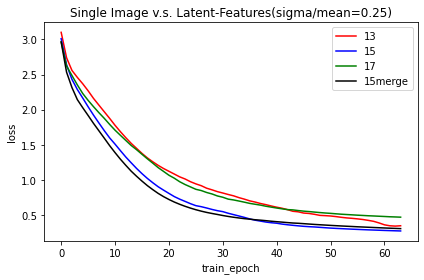

In [45]:
epoch=list(range(64))
plt.plot(epoch,loss13,'r')
plt.plot(epoch,loss15,'blue')
plt.plot(epoch,loss17,'g')
plt.plot(epoch,lossM15_,'black',)
plt.xlabel("train_epoch")
plt.ylabel("loss")
plt.title('Single Image v.s. Latent-Features(sigma/mean=0.25)')
plt.legend(['13','15','17','15merge'],loc='best')
plt.tight_layout()
plt.show()

In [56]:
res15M1=cv2.imread(r"E:\project\images\researchImage\images\labelsets\latentMergeResult\15_262.tif",0)
res15M2=cv2.imread(r"E:\project\images\researchImage\images\labelsets\latentMergeResult\15.tif",0)
res15=cv2.imread(r"E:\project\images\researchImage\images\labelsets\multiyearSegCompare12_11\15.tif",0)
res13=cv2.imread(r"E:\project\images\researchImage\images\labelsets\multiyearSegCompare12_11\13.tif",0)
res17=cv2.imread(r"E:\project\images\researchImage\images\labelsets\multiyearSegCompare12_11\17.tif",0)

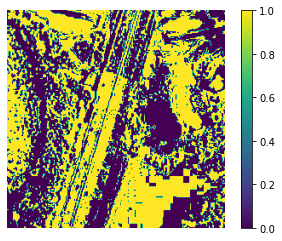

In [58]:
output = np.abs(img15-res15)
output[output>200] = 0
output[output>1] = 1

fig = plt.figure()
plt.axis('off')
heatmap = plt.imshow(output, cmap='viridis')
fig.colorbar(heatmap)
# fig.savefig('label_heatmap.png')

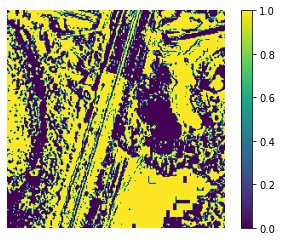

In [59]:
output = np.abs(img15-res15M1)
output[output>200] = 0
output[output>1] = 1

fig = plt.figure()
plt.axis('off')
heatmap = plt.imshow(output, cmap='viridis')
fig.colorbar(heatmap)

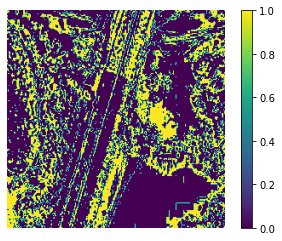

In [65]:
output = np.abs(img15-res15M2)
output[output<240] = 0
output[output>=240] = 1

fig = plt.figure()
plt.axis('off')
heatmap = plt.imshow(output, cmap='viridis')
fig.colorbar(heatmap)

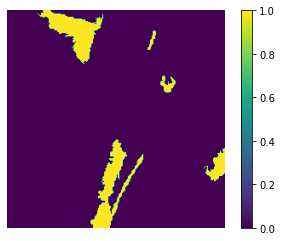

In [66]:
output = np.abs(res15M1-res15M2)
output[output<240] = 0
output[output>240] = 1

fig = plt.figure()
plt.axis('off')
heatmap = plt.imshow(output, cmap='viridis')
fig.colorbar(heatmap)